In [1]:
# Preparations
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from itertools import compress
from pyflann import *

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2
from scipy.misc import imresize, imsave
from scipy import sparse

from skimage.transform import resize, rotate, SimilarityTransform
from skimage.io import imread
from skimage.measure import ransac
from skimage.color import rgb2gray

from utils import findNeighbours, kdtreequery, matchWords, plotMatches, geometricVerification, getHistogramFromDescriptor, plotRetrievedImages, plotFrameBoth

import time

In [1]:
# Description:
#    Exercise7 VGG practical notebook (Part3, fast track).
#
# This software is inspired by original object instance recognition
# VGG practical. 
# Licence; please refer to the file 
# Licence.txt, included with the software, for details.

# CS-E4850 Computer Vision Exercise Round 7

This is a minimal python version of Oxford Visual Geometry Group's Matlab$^{\texttt{TM}}$ practical on recognition of object instances (see the original webpage <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#part3>here</a>). By "minimal" it is meant that it uses pre-computed SIFT features and some other needed resources. All of them are calculated using the freely available matlab scripts found in the practical's github <a href=https://github.com/vedaldi/practical-object-instance-recognition >repository</a>. The practical is largely based on the vlfeat library (cf. http://www.vlfeat.org/) which unfortunately does not have a Python interface. <br><br>

This notebook is <b>the third part (PART II)</b> of the practical on the so-called <em>fast-track</em> and demonstrates <b>the operation of a large scale image retriaval system</b>.
<br><br>
Go through the notebook and answer the questions given in the practical's webpage. 

## Part III: Towards large scale retrieval

The goal of large scale retrieval is to match a query image to (possibly) a very large database of images (for example Flickr). The goodness or quality of a match is evaluated as the number of (usually geometrically verified) feature correspondences between the query and a database image. While the techniques discussed in the previous parts are sufficient to do this, in practice they are often too memory hungry so that storing the SIFT descriptors for all the detections in all the database images would be feasible. Next, two key ideas are explored: (i) one to reduce the memory footprint and pre-compute descriptor matches, and (ii) the other to speed up image retrieval.

In [2]:
## -------------------------------------------------------------------
#      Preparations
# --------------------------------------------------------------------

# Load images (rgb2gray is used here just to easen plotting)
im1 = imread('data/oxbuild_lite/ashmolean_000007.jpg') / 255.
im2 = imread('data/oxbuild_lite/ashmolean_000028.jpg') / 255.

# Prepare montage
#im2 = np.vstack((im2, np.zeros((1024-768, 1024))))

## Load precomputed data 
# SIFT feature points and descriptors for im1 and im2, and quantized descriptors' word vocabulary
data1=np.load("./data/img1_sift_kps_descs.npy", encoding='latin1')
kps1 = data1.item().get('keypoints')
descrs1 = data1.item().get('descriptors')

data2=np.load("./data/img2_sift_kps_descs.npy", encoding='latin1')
kps2 = data2.item().get('keypoints')
descrs2 = data2.item().get('descriptors')

vocab = np.load("./data/sift_disc_vocab.npy", encoding='latin1')

# Get the matches based on the raw descriptors
tic = time.clock()
ind, dist = findNeighbours(descrs1, descrs2, numNeighbors=2)
nnThreshold = 0.85
ratio2 = np.divide(dist[:,0], dist[:,1])
ok = ratio2 <= nnThreshold ** 2
matches_raw = np.vstack((np.nonzero(ok), ind[ok, 0]))
matches_raw = matches_raw.T
time_raw = time.clock()-tic


NameError: name 'imread' is not defined

### Stage III.A: Accelerating descriptor matching with visual words

Continue reading the notes of Stage III.A and answer the questions.

Type your answers here (there are three questions):

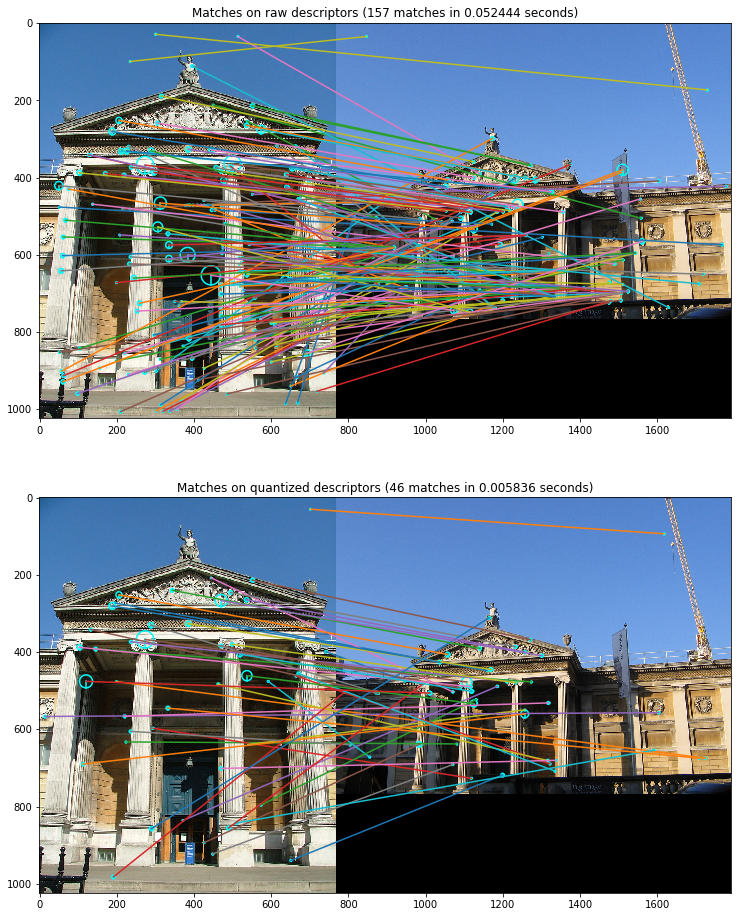

In [8]:
## -------------------------------------------------------------------
#      Stage III.a: Accelerating descriptor matching with visual words
# --------------------------------------------------------------------

# Quantise the descriptors
words1 = kdtreequery(vocab, descrs1, maxNumChecks=1024)
words2 = kdtreequery(vocab, descrs2, maxNumChecks=1024)

# Get the matches based on quantized descriptors
tic = time.clock()
matches_word = matchWords(words1, words2)
time_word = time.clock()-tic

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(32,16))
ax = axes.ravel()
#plt.suptitle("Matches before geometric verification", fontsize=20)
plotFrameBoth(ax[0], im1, im2, kps1, kps2, matches_raw, plotMatches=True)
#plotMatches(ax[0], im1, im2, kps1, kps2, matches_raw)
ax[0].set_title("Matches on raw descriptors ({} matches in {} seconds)".format(len(matches_raw), time_raw))
plotFrameBoth(ax[1], im1, im2, kps1, kps2, matches_word, plotMatches=True)
#plotMatches(ax[1], im1, im2, kps1, kps2, matches_word)
ax[1].set_title("Matches on quantized descriptors ({} matches in {} seconds)".format(len(matches_word), time_word))

plt.show()

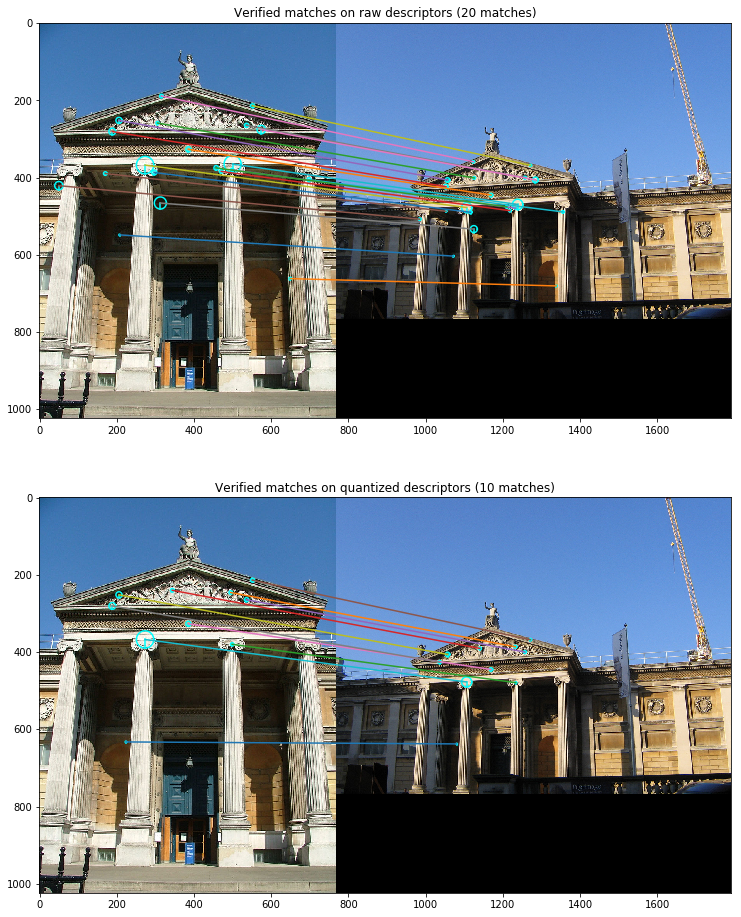

In [11]:
# Count inliers, i.e. perform geometric verification
inliers_raw, H_raw = geometricVerification(kps1, kps2, matches_raw, 3)
inliers_word, H_word = geometricVerification(kps1, kps2, matches_word, 3)

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(32,16))
ax = axes.ravel()
#plt.suptitle("Matches after geometric verification", fontsize=20)
plotFrameBoth(ax[0], im1, im2, kps1, kps2, matches_raw[inliers_raw,:], plotMatches=True)
ax[0].set_title("Verified matches on raw descriptors ({} matches)".format(len(matches_raw[inliers_raw,:])))
plotFrameBoth(ax[1], im1, im2, kps1, kps2, matches_word[inliers_word,:], plotMatches=True)
ax[1].set_title("Verified matches on quantized descriptors ({} matches)".format(len(matches_word[inliers_word,:])))

plt.show()

### Step III.b: Searching with an inverted index
Continue reading the notes of Stage III.B and answer the questions.

Type your answers here (there is only one question):

IMPORTANT NOTE: The top image does not have here (in this python practical) a score of 1 (but ~0.97 instead). This is because the computations for the database images were entirely (including descriptor quantization) done in Matlab using the VLfeat library. For the query, in turn, the words are generated using a pyflann-based implementation (check utils.py). The difference in scores reflects the fact that the given descriptor quantization methods (here and the one in the matlab practical) produce both a bit different quantization result with the same vocabulary and descriptors. If the words of the database images were generated in a similar manner than for the query the top score would be 1 (as it is the same image), or other way around, it would be 1 if the words for the query were also generated using the matlab version. Now, your task is just to pretend that the score was 1 (like it should be in reality) and answer the question.


In [12]:
## -------------------------------------------------------------------
#                        Stage III.B: Searching with an inverted index
# --------------------------------------------------------------------

# We are using im2 as the query.

## Load precomputed data 
# SIFT feature points and descriptors for im2 (note that we are using affine robust SIFT features)
data2=np.load("./data/img2_sift_ellipse_kps_descs.npy", encoding='latin1')
kps2 = data2.item().get('keypoints')
descrs2 = data2.item().get('descriptors')

# Load all imdb related resources
data = np.load("./data/imdb.npy", encoding='latin1')

index = data.item().get('index') # all sift feature histograms of the database images
vocab = data.item().get('vocabulary') # visual word vocabulary (ellipse)
idf = data.item().get('idf') # inverse document frequency 
imdbImDir = data.item().get('imdir') # imgfile information
imdbImNames = data.item().get('imnames')
imdbImWords = data.item().get('imwords') # quantized sift descriptors
imdbImKps = data.item().get('imkps') # keypoint frames of database images

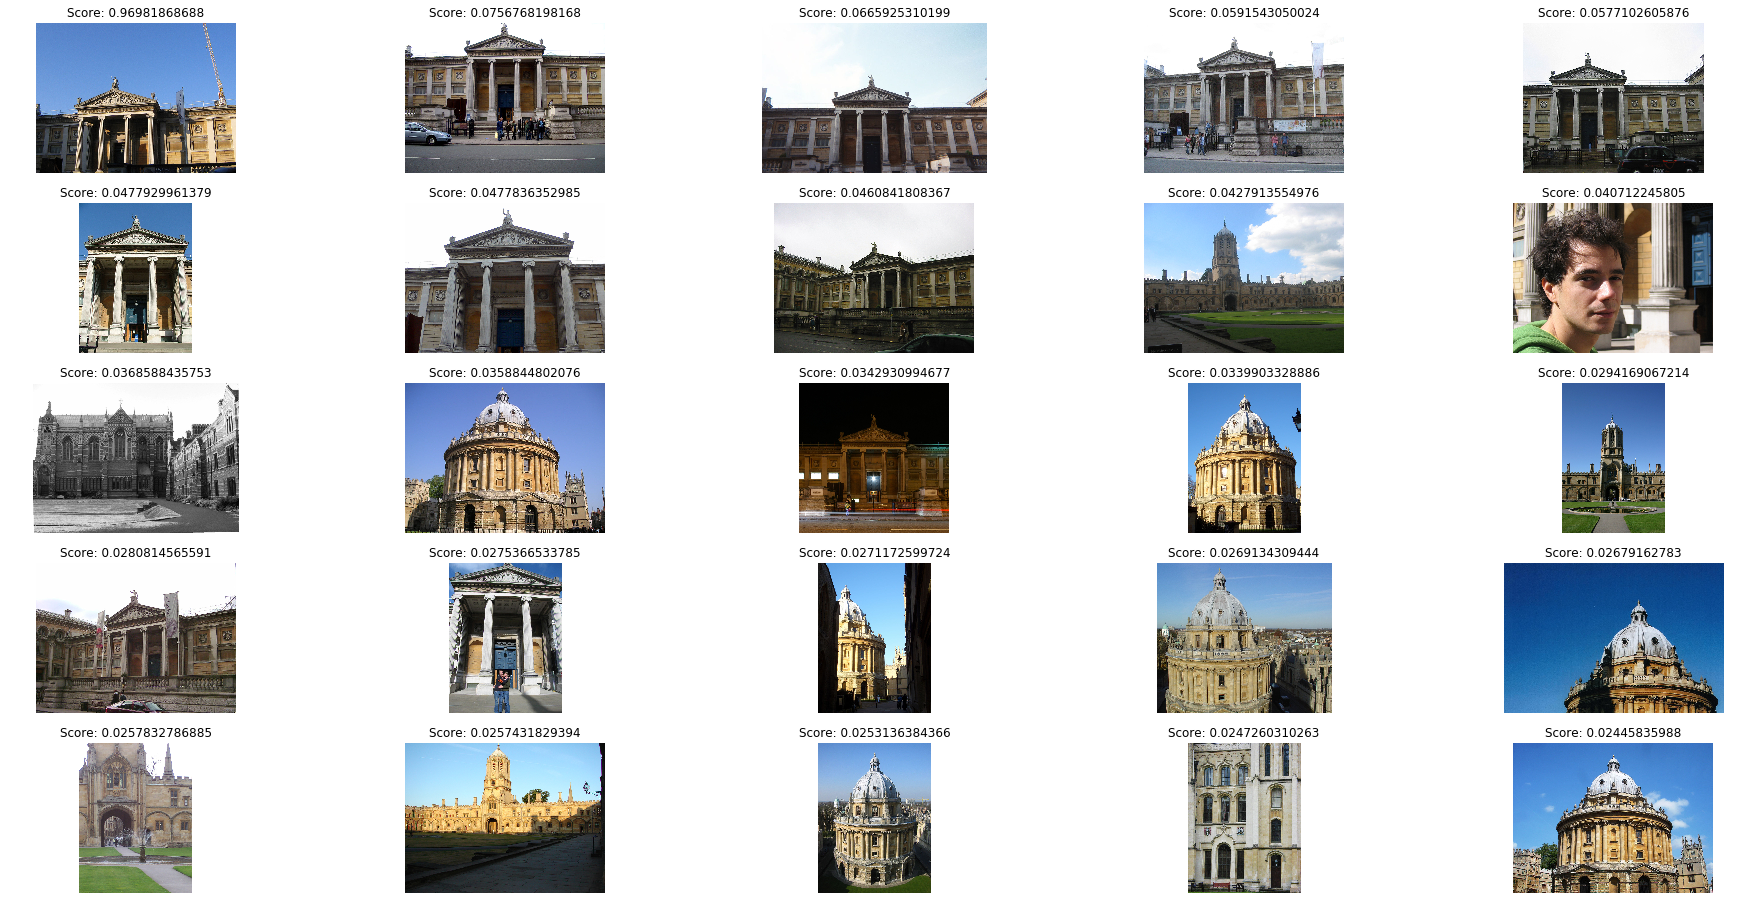

In [13]:
h = getHistogramFromDescriptor(vocab, idf, descrs2)

# Score the other images by similarity to the query
tic = time.clock()
scores = index.dot(h)
time_index = time.clock() - tic
scores = scores.squeeze()

plotRetrievedImages(imdbImDir, imdbImNames, scores, 25)

### Stage III.C: Geometric rescoring
Continue reading the notes of Stage III.C and answer the questions.

Type your answers here (there are two questions altogether):


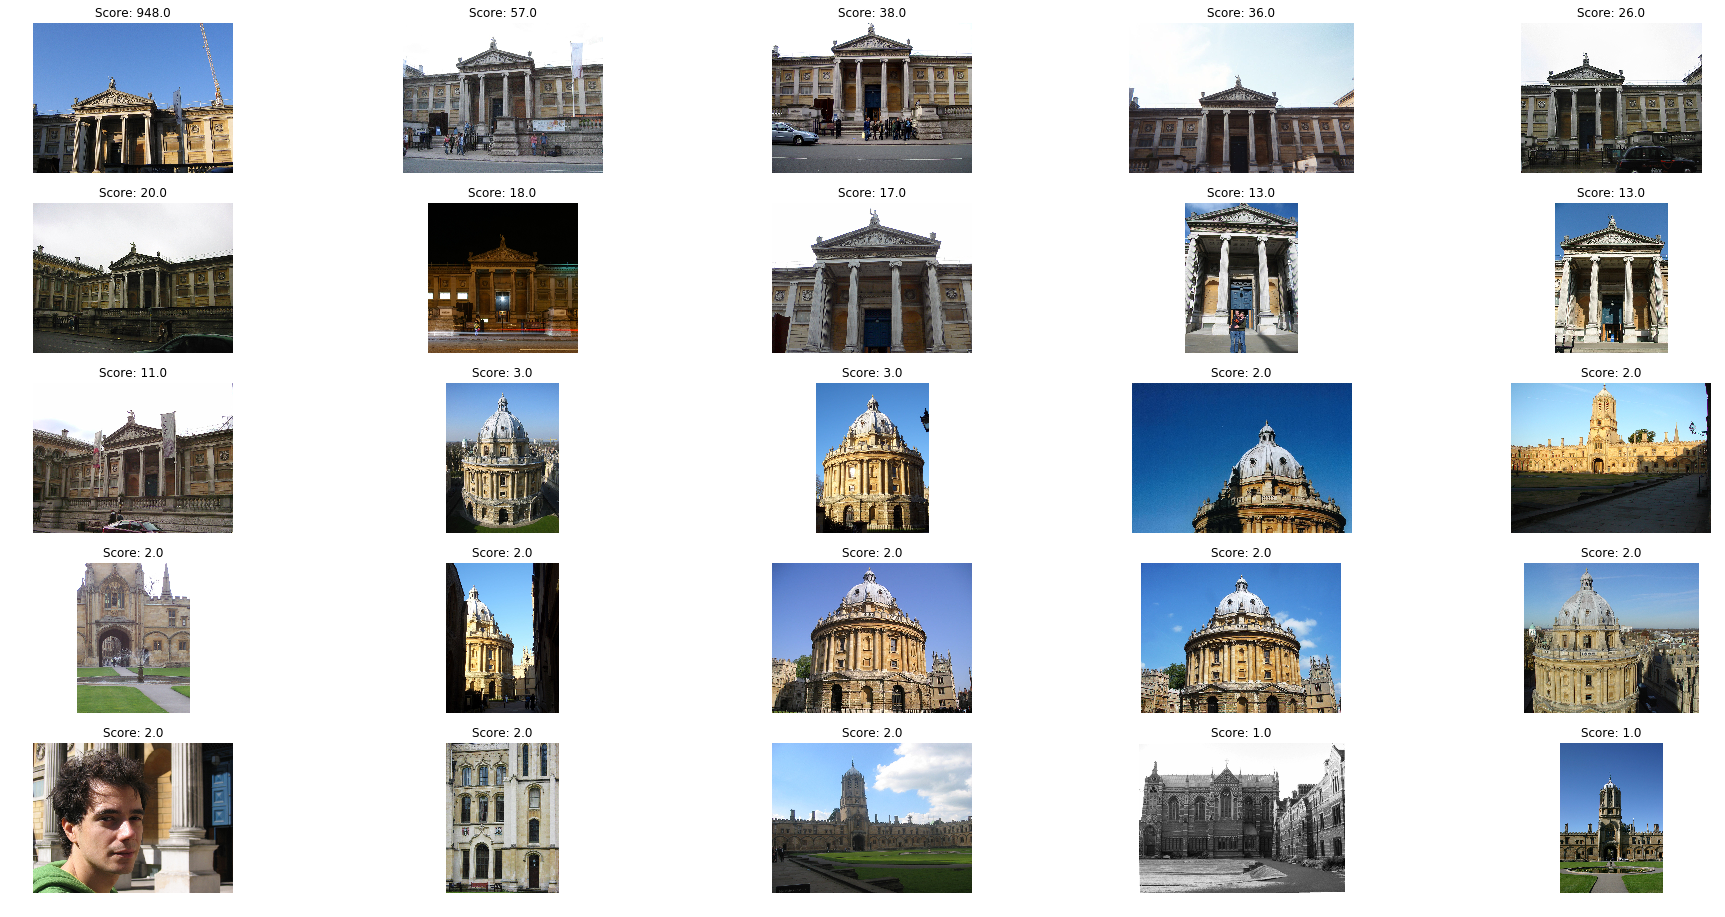

In [14]:
## -------------------------------------------------------------------
#                                    Stage III.C: Geometric reranking
# --------------------------------------------------------------------

# Rescore the top 25 images based on the number of
# inlier matches.

sorted_scores = np.sort(scores, axis=0)
id_sorted_scores = np.argsort(scores, axis=0)
sorted_scores = sorted_scores[::-1]
id_sorted_scores = id_sorted_scores[::-1]

words = kdtreequery(vocab, descrs2, maxNumChecks=1024)

for rank in range(25):
    ii = id_sorted_scores[rank]
    db_instance_words = imdbImWords[ii]
    matches = matchWords(words, db_instance_words)
    instance_kps = imdbImKps[ii].T
    inliers_word, H_word = geometricVerification(kps2, instance_kps, matches, 3)
    newScore = len(inliers_word)
    scores[id_sorted_scores[rank]] = newScore

# Plot results by decreasing score
plotRetrievedImages(imdbImDir, imdbImNames, scores, 25)
